# Timing Data

In [2]:
from time_solvers import timed_trials, plot_solver_run_times
import numpy as np

Error:No module named 'pyximport'


In [3]:
from gillespy2 import StochKitSolver, NumPySSASolver, OptimizedSSASolver, SSACSolver
from gillespy2.example_models import Example, Trichloroethylene, MichaelisMenten, Schlogl
modelList = [Example(), Trichloroethylene(), MichaelisMenten(), Schlogl()]
solverList = [ StochKitSolver, NumPySSASolver, OptimizedSSASolver, SSACSolver]

In [6]:
import os
os.environ['STOCHKIT_HOME'] = "/Users/bdrawert/Desktop/research/StochKit"

In [7]:
trajectories = [2**i for i in range(11)]
timing_data = timed_trials(modelList, solverList, trajectories, number_trials=30,output_file='timing_data.pkl')

Model: Example, Solver: StochKitSolver, Trajectories: 1: 100%|██████████| 30/30 [00:01<00:00, 20.00it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 2: 100%|██████████| 30/30 [00:01<00:00, 19.23it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 4: 100%|██████████| 30/30 [00:01<00:00, 18.58it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 8: 100%|██████████| 30/30 [00:01<00:00, 16.95it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 16: 100%|██████████| 30/30 [00:02<00:00, 14.38it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 32: 100%|██████████| 30/30 [00:02<00:00, 11.07it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 64: 100%|██████████| 30/30 [00:03<00:00,  7.57it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 128: 100%|██████████| 30/30 [00:06<00:00,  4.73it/s]
Model: Example, Solver: StochKitSolver, Trajectories: 256: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s]
Model: Example, Solver: StochKitSolver, Trajecto

Model: Trichloroethylene, Solver: CythonSSASolver, Trajectories: 256: 100%|██████████| 30/30 [03:06<00:00,  6.21s/it]
Model: Trichloroethylene, Solver: CythonSSASolver, Trajectories: 512: 100%|██████████| 30/30 [06:13<00:00, 12.44s/it]
Model: Trichloroethylene, Solver: CythonSSASolver, Trajectories: 1024: 100%|██████████| 30/30 [12:27<00:00, 24.90s/it]
Model: Trichloroethylene, Solver: SSACSolver, Trajectories: 1: 100%|██████████| 30/30 [00:00<00:00, 115.51it/s]
Model: Trichloroethylene, Solver: SSACSolver, Trajectories: 2: 100%|██████████| 30/30 [00:00<00:00, 104.69it/s]
Model: Trichloroethylene, Solver: SSACSolver, Trajectories: 4: 100%|██████████| 30/30 [00:00<00:00, 91.75it/s]
Model: Trichloroethylene, Solver: SSACSolver, Trajectories: 8: 100%|██████████| 30/30 [00:00<00:00, 74.23it/s]
Model: Trichloroethylene, Solver: SSACSolver, Trajectories: 16: 100%|██████████| 30/30 [00:00<00:00, 54.75it/s]
Model: Trichloroethylene, Solver: SSACSolver, Trajectories: 32: 100%|██████████| 30/30 

Model: Schlogl, Solver: NumPySSASolver, Trajectories: 8: 100%|██████████| 30/30 [00:01<00:00, 19.56it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 16: 100%|██████████| 30/30 [00:03<00:00,  9.71it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 32: 100%|██████████| 30/30 [00:06<00:00,  4.95it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 64: 100%|██████████| 30/30 [00:12<00:00,  2.46it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 128: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 256: 100%|██████████| 30/30 [00:48<00:00,  1.62s/it]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 512: 100%|██████████| 30/30 [01:37<00:00,  3.23s/it]
Model: Schlogl, Solver: NumPySSASolver, Trajectories: 1024: 100%|██████████| 30/30 [03:14<00:00,  6.49s/it]
Model: Schlogl, Solver: CythonSSASolver, Trajectories: 1: 100%|██████████| 30/30 [00:00<00:00, 150.38it/s]
Model: Schlogl, Solver: CythonSSASolver, 

In [4]:
#Ideally, we can run the timed tests once and save the results for later in a .pkl file
import pickle
with open('timing_data.pkl', 'rb') as f:
    timing_data = pickle.load(f)
    
%matplotlib inline
styles = {
    'StochKitSolver' : 'r*-',
    'SSACSolver' : 'g*-',
    'CythonSSASolver' : 'b*-',
    'NumPySSASolver' : 'k*-'    
}

In [5]:
1+1

2

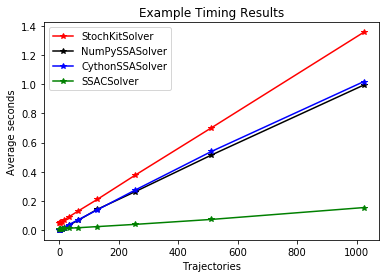

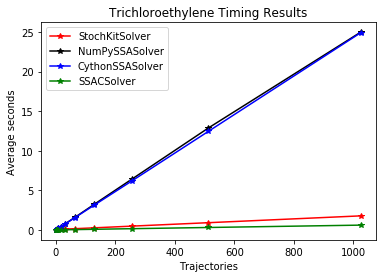

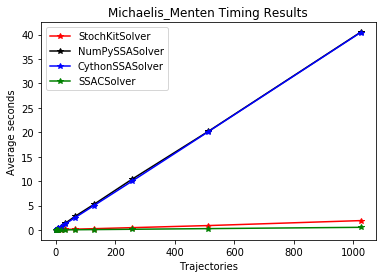

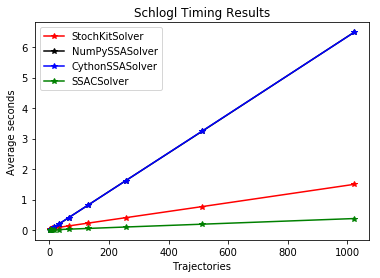

In [6]:
plot_solver_run_times(timing_data, line_styles=styles)

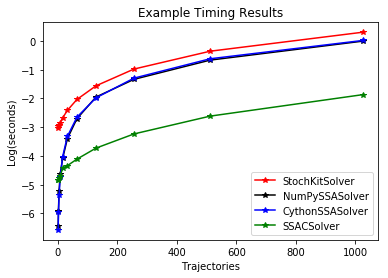

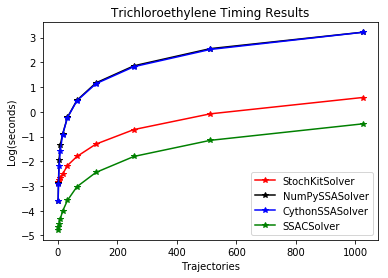

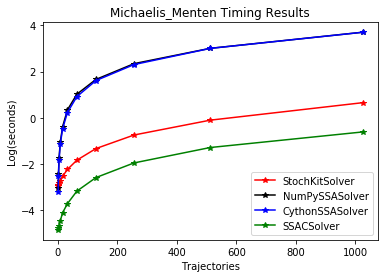

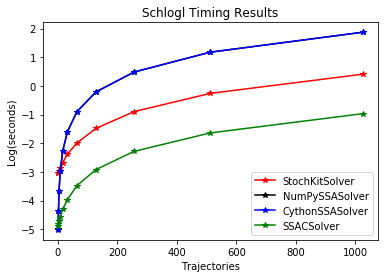

In [7]:
plot_solver_run_times(timing_data, line_styles=styles, ylabel='Log(seconds)', transformation=np.log)

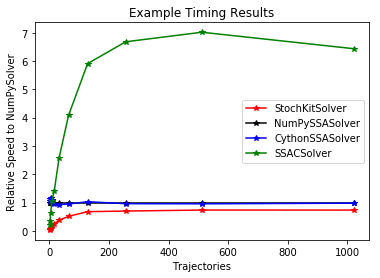

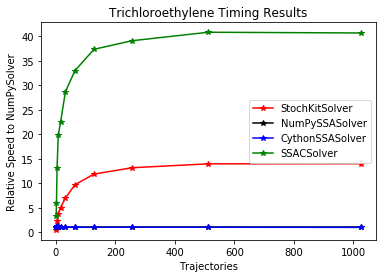

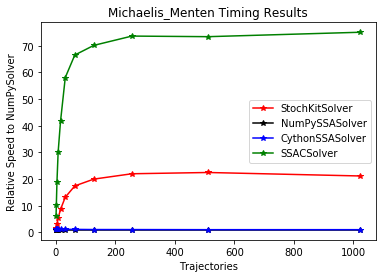

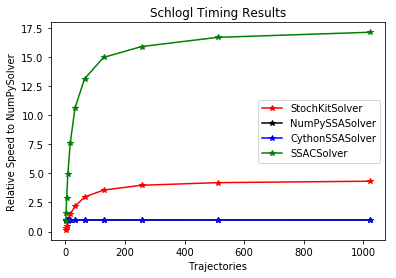

In [8]:
plot_solver_run_times(timing_data, line_styles=styles, ylabel='Relative Speed to NumPySolver', baseline_solver_name=NumPySSASolver.name)